# Changes from v4: 
* settled on:
    * remove epochs w/ >0.25s of eye movement artifacts
    * remove a channel from mean of a given stage if <20 artifact-free epochs of that stage
    * used non-overlapping 3s window
    * 2-taper multitaper
    * normalize by 1-55 Hz (because 0-1 Hz is very affected by eye movement artifact)
        
* TO DO:
    * calc % epochs removed for each reason

# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import resin
import pandas as pd

import scipy.fftpack as fft

from pandas import DataFrame,Series,read_table

General info

In [2]:
savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig S2/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)
saveAsPath = './Fig 04/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)    
    
saveAsPath = './Fig 04/'
saveAsName = 'Fig'

In [3]:
#path = '/Users/svcanavan/Dropbox/Coding in progress/00_BudgieSleep/Data_copies/'

birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['6 LEEGm-LEEGp', '5 LEEGf-LEEGp'], #, '9 REEGp-LEEGp'], # extra channel to represent R hemisphere
                     ['5 LEEGf-LEEGm', '4 LEEGf-Fgr'], #, '9 REEGf-REEGm'], # extra channel to represent R hemisphere
                     ['9REEGm-REEGp', '4LEEGf-LEEGp'], 
                     ['6LEEGm-LEEGf', '9REEGf-REEGp'], 
                     ['7REEGf-REEGp', '4LEEGf-LEEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events: use folder w/ EMs and EM artifacts detected during non-sleep
events_path = '../data_copies/SWs_EMs_and_EMartifacts/'

In [4]:
# Adjust stages: include 6 for Waking hemisphere during US:
stages = ['w','d','u','i','s','r','a']
stage_names = ['wake', 'drowsy', 'US_sleeping', # US sleeping: the hemisphere that's asleep
               'IS', 'SWS', 'REM', 'US_awake']  # US awake: the hemisphere that's awake


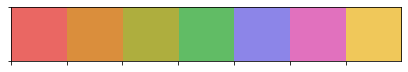

In [5]:
# Adjust to include a color for 6: Waking hemisphere during US
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190],
[240,200,90]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

Plot-specific info

In [6]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

### plotLegend

In [7]:
# Markers for legends of EEG scoring colors

def plotLegend(stage_nums, labels, loc='upper right'):
    legendMarkersEEG = []
    for stage in stage_nums:
        legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], lw=linewidth/2,  alpha=0.7))  

    plt.legend(legendMarkersEEG, labels, loc=loc)


   

Calculate general variables

In [8]:
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

nBirds = len(birdPaths)

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

birds = ['1', '2', '3', '4', '5']
         #'2LL', '3LL', '4LL'] # import LL

# Read in files

## Load EEG: add padding to the end of each file & create time index

In [9]:
EEGdataAll = {}
TimeIndexEEG = {}
TimeIndexPower = {}

for b_num in birds: 
    
    b = int(b_num[0]) - 1   
        
##### arf files for all datasets except 4LL
    
    if '4LL' not in b_num:
    
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]

        for channel in channelsToLoadEEG_best[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.arf'):
                    arffile = h5py.File(arf_path+file, 'r')
                    data_array = arffile['.'][channel][()]
                    data_array = np.ndarray.flatten(data_array)

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

            # Do not reshape

            # Save in dict under bird number and channel
            data_name = 'Bird ' + b_num + ': ' + channel
            EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### bark files for 4LL

    elif '4LL' in b_num:
        if 'LL' in b_num:
            arf_path = birdPaths_LL[b-1] + arfFilePaths_LL[b-1]
        else:
            arf_path = birdPaths[b] + arfFilePaths[b]
        
        for channel in channelsToLoadEEG_best[b]:
            all_data_array = np.array([])

            for file in np.sort(os.listdir(arf_path)):
                if file.endswith('.dat'):
                    dset = bark.read_sampled(arf_path + file)

                    # get channel number
                    ch_num = [x for x in dset.attrs['columns'].keys() if channel in dset.attrs['columns'][x]['channel_name']]
                    if len(ch_num) != 1:
                        print("for bird", b_num, "channel", channel, ": correct number of channels not found")

                    data_array = dset.data[:, ch_num]
                    data_array = np.array(np.ndarray.flatten(data_array))  # flatten and take out of memmap modes

                    # Pad the end with NaN's to make it divisible by epoch length
                    nanPadding = np.zeros(epochLengthPts - np.mod(len(data_array), epochLengthPts))
                    nanPadding.fill(np.nan)
                    data_array = np.append(data_array,nanPadding)   

                    all_data_array = np.append(all_data_array,data_array)

                # Do not reshape

                # Save in dict under bird number and channel
                data_name = 'Bird ' + b_num + ': ' + channel
                EEGdataAll[data_name] = scalingFactor * all_data_array
    
##### Create time index for EEG

    all_time_array = np.array([], dtype='datetime64')
    for file in np.sort(os.listdir(arf_path)):
        if file.endswith('.arf')|file.endswith('.dat'):

            date = file.split('_')[2]

            if (b == 0) & ('2014-10-17' in file):
                hours = '17'
                minutes = '32'
            elif b == 0:
                hours = '09'
                minutes = '00'
            else:
                time = file.split('_')[3].split('.')[0]
                hours = time.split('-')[0]
                minutes = time.split('-')[1]

            datetime_start = np.datetime64(date + 'T' + hours + ':' + minutes + ':06')    # assume 6-s delay in starting recording

            # time index in datetime format
            
            if file.endswith('.arf'):
                arffile = h5py.File(arf_path+file, 'r')
                length_pts   = len(arffile['.'][channel][()])
            elif file.endswith('.dat'):
                length_pts   = len(bark.read_sampled(arf_path + file).data[:,0])
            
            padding_pts = epochLengthPts - np.mod(length_pts, epochLengthPts)
            length_s = (length_pts+padding_pts)/sr
            length_ms = np.timedelta64(int(1000 * length_s), 'ms')
            datetime_end = datetime_start + length_ms

            time_array = np.arange(datetime_start, datetime_end, np.timedelta64(int(1000/sr),'ms')) 

            # Add to end of whole-night time index
            all_time_array = np.append(all_time_array, time_array)


    data_name = 'Bird ' + b_num
    TimeIndexEEG[data_name] = all_time_array
    
    # Get time at the start of each epoch
    TimeIndexPower[data_name] = all_time_array[np.arange(0,len(all_time_array),epochLengthPts)]
    

EEGchannels = np.sort(list(EEGdataAll.keys()))

## Load scores from CSVs

### Bring scores into alignment with padded EEGs

In [10]:
AllScores = {}
for b in birds:
    # Load from file
    scores_file = 'All_scores_Bird {}.csv'.format(b)
    tmp_scores = pd.read_table(formatted_scores_path + scores_file, sep=',', index_col=0)

    # Reindex according to TimeIndexPower for that bird
    tmp_time_index = TimeIndexPower['Bird ' + str(b)]
    tmp_scores = tmp_scores.reindex(pd.to_datetime(tmp_scores.index)) # convert original index to pandas datetimes
    tmp_scores = tmp_scores[~tmp_scores.index.duplicated()] # remove any duplicates
    reindexed_scores = tmp_scores.reindex(pd.to_datetime(tmp_time_index)) # reindex with EEG-based index
    
    # save to dict
    AllScores['Bird ' + str(b)] = reindexed_scores    

## Mark artifacts for each channel

### Any epochs marked as 'moving', 'preening', or 'singing' on the video label

In [11]:
for b in birds:
    scores = AllScores['Bird ' + str(b)]
    ix_moving = scores[(scores['Video Label']=='m')|(scores['Video Label']=='p')|(scores['Video Label']=='si')].index
    scores['Label (#)'].loc[ix_moving] = -1
    AllScores['Bird ' + str(b)] = scores

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


### Track number of epochs removed

In [12]:
AllEpochs = {} # init --> get number of epochs
track_stages = [0,1,2,3,4,5,6]

nEpochs_orig = pd.DataFrame([])
nEpochs_highamp_rm = pd.DataFrame([])
nEpochs_EMart_rm = pd.DataFrame([])
        


### Any epochs w/ data that crosses an amplitude threshold
### + categorize unihem sleep by hemisphere

In [13]:
# Set thresholds
#artifact_threshold_uV = 400
artifact_threshold_SD  = 4   # of SDs away from mean

# Make a scores array for each channel so it has independent artifact removal
ChannelScores = {}

for ch in EEGchannels:
    b_name = ch[0:6]
    # get scores as an array of numbers
    bird_scores = AllScores[b_name]
    ch_scores = pd.Series(bird_scores['Label (#)'].values, index=bird_scores['Epoch #'])
    
#### UNIHEMISPHERIC SLEEP
    # for L sided channels, get L unihem sleep
    if 'LEEG' in ch:
        US_wakehem_inds  = bird_scores[bird_scores['Label']=='g']['Epoch #']
    # for R sided channels, get R unihem sleep
    elif 'REEG' in ch:
        US_wakehem_inds  = bird_scores[bird_scores['Label']=='l']['Epoch #']
    else:
        print('unclear if channel is L or R hemisphere')
    # set waking hemisphere epochs to 6
    ch_scores.loc[US_wakehem_inds] = 6
    
    # track original nEpochs of each stage
    nEpochs_orig[ch] = ch_scores.value_counts()[track_stages]
    
#### AMPLITUDE ARTIFACTS
    
    nEpochs = len(bird_scores)
    data = EEGdataAll[ch]

    # mean + N*SD
    artifact_threshold_SD_uV = (data[~np.isnan(data)]).mean() + artifact_threshold_SD*(data[~np.isnan(data)]).std()
    print(ch + ' : ' + str(artifact_threshold_SD_uV))
    
    #artifact_threshold = np.max([artifact_threshold_uV, artifact_threshold_SD_uV])
    artifact_threshold = artifact_threshold_SD_uV
        

    for ep in range(nEpochs):
        start_pts = ep * epochLengthPts
        stop_pts  = (ep+1) * epochLengthPts
        
        ep_data = data[start_pts:stop_pts]
        
        if any(np.abs(ep_data) > artifact_threshold):
            ch_scores.loc[ep] = -2
            
    # Save to dataframe
    ChannelScores[ch] = ch_scores
    
    # track nEpochs of each stage after high-amp artifacts removed
    nEpochs_highamp_rm[ch] = ch_scores.value_counts()[track_stages]
    
AllEpochs['nEpochs'] = nEpochs_orig
AllEpochs['nEpochs high amp removed'] = nEpochs_highamp_rm
    

Bird 1: 5 LEEGf-LEEGp : 279.2679036087251


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


Bird 1: 6 LEEGm-LEEGp : 465.24488691372113
Bird 2: 4 LEEGf-Fgr : 504.72536588215985
Bird 2: 5 LEEGf-LEEGm : 260.6034616921849
Bird 3: 4LEEGf-LEEGp : 434.3907547931754


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Bird 3: 9REEGm-REEGp : 565.1595695127436
Bird 4: 6LEEGm-LEEGf : 305.3846764062442
Bird 4: 9REEGf-REEGp : 390.99383856831656
Bird 5: 4LEEGf-LEEGp : 362.4612557939865
Bird 5: 7REEGf-REEGp : 307.9690407823895


## Exclude epochs with excess eye movement artifact

In [14]:
# load straight from collated file

EMartifacts = {}

for bird in birds:
    data = pd.read_csv(events_path + 'Fig05_Bird ' + str(bird) + '_SW-EM-per-epoch.csv', index_col=0)
    
    EM_artifact_channels = [x.split(':')[-1][1::] for x in data.columns if 'EM artifact s' in x]
    
    for ch in EM_artifact_channels:

        ch_name = 'Bird ' + bird + ': ' + ch
        EMartifacts[ch_name] = data['EM artifact s: ' + ch]

In [15]:
# For each bird find epochs with too much EM artifact
EM_artifact_thres = .25  # in seconds/epoch
for ch in EEGchannels:

    bird = int(ch[5])-1
    #bird_name = "Bird " + ch[5]

    # Get EM artifact data for that channel
    tmp_data = EMartifacts[ch]
    #tmp_data = tmp_data.reindex(AllScores[bird_name]['Epoch #'])

    inds_artifacts = tmp_data[tmp_data > EM_artifact_thres].index

    ch_scores = ChannelScores[ch].copy()
    inds_artifacts = [x for x in inds_artifacts if x in ch_scores.index] # get only inds that are listed in ch scores

    print(ch + ": " + str(len(inds_artifacts)) + " epochs removed")
    print(pd.Series(ch_scores[inds_artifacts]).value_counts())
    ch_scores.loc[inds_artifacts] = -3

    # Save to dataframe
    ChannelScores[ch] = ch_scores
    
    # track nEpochs of each stage after EM artifacts removed
    nEpochs_EMart_rm[ch] = ch_scores.value_counts()[track_stages]
    
AllEpochs['nEpochs EM artifacts removed'] = nEpochs_EMart_rm
    

Bird 1: 5 LEEGf-LEEGp: 15806 epochs removed
-1.0    4391
-2.0    3801
 1.0    2198
 0.0    1591
 3.0    1417
 5.0    1408
 4.0     823
 2.0      94
 6.0      83
dtype: int64
Bird 1: 6 LEEGm-LEEGp: 16023 epochs removed
-1.0    4311
-2.0    3865
 1.0    2259
 0.0    1683
 3.0    1510
 5.0    1351
 4.0     863
 6.0      94
 2.0      87
dtype: int64
Bird 2: 4 LEEGf-Fgr: 20546 epochs removed
-1.0    6065
 0.0    5786
 1.0    2728
 3.0    1824
-2.0    1692
 5.0    1562
 2.0     398
 4.0     284
 6.0     207
dtype: int64
Bird 2: 5 LEEGf-LEEGm: 22086 epochs removed
-1.0    6072
 0.0    5838
 1.0    2750
 3.0    2595
 5.0    2063
-2.0    1739
 4.0     430
 2.0     395
 6.0     204
dtype: int64
Bird 3: 4LEEGf-LEEGp: 12633 epochs removed
 1.0    3365
 3.0    2798
-1.0    1911
 0.0    1403
 4.0    1160
 5.0     922
-2.0     696
 2.0     233
 6.0     145
dtype: int64
Bird 3: 9REEGm-REEGp: 17215 epochs removed
 1.0    5133
 3.0    3456
 0.0    2291
-1.0    2103
 4.0    1366
-2.0    1315
 5.0     809

### Collate %s of epochs removed

In [16]:
AllEpochs['nEpochs EM artifacts removed']

,Bird 1: 5 LEEGf-LEEGp,Bird 1: 6 LEEGm-LEEGp,Bird 2: 4 LEEGf-Fgr,Bird 2: 5 LEEGf-LEEGm,Bird 3: 4LEEGf-LEEGp,Bird 3: 9REEGm-REEGp,Bird 4: 6LEEGm-LEEGf,Bird 4: 9REEGf-REEGp,Bird 5: 4LEEGf-LEEGp,Bird 5: 7REEGf-REEGp
0,1023,1014,622,570,1720,731.0,1277.0,727.0,1229,3297.0
1,1611,1667,324,302,3131,1171.0,2532.0,1229.0,3625,8013.0
2,24,26,7,10,415,NaN,NaN,NaN,70,NaN
3,2846,2972,3994,3223,5046,4391.0,6481.0,3841.0,5827,6593.0
4,1426,1484,944,798,1655,1467.0,3043.0,1969.0,1442,1610.0
5,3049,3192,2034,1533,1332,1445.0,1996.0,989.0,1979,2913.0
6,83,95,6,9,135,91.0,43.0,21.0,167,439.0


In [17]:
((AllEpochs['nEpochs'] - AllEpochs['nEpochs high amp removed'])/AllEpochs['nEpochs']).mean(axis=1)

0    0.075889
1    0.079802
2    0.075277
3    0.044678
4    0.041730
5    0.038917
6    0.068133
dtype: float64

In [18]:
((AllEpochs['nEpochs high amp removed'] - AllEpochs['nEpochs EM artifacts removed'])/AllEpochs['nEpochs']).mean(axis=1)

0    0.531681
1    0.547646
2    0.674143
3    0.293458
4    0.289075
5    0.363921
6    0.441104
dtype: float64

# NUMBER OF UNIHEM EXAMPLES
* did not include spectra from birds with <20 epochs (artifact-free)

In [19]:
for ch in ChannelScores.keys():
    ch_scores = ChannelScores[ch]
    print(ch)
    print('\t US asleep hem:', ch_scores.value_counts().get(2))
    print('\t US awake hem: ', ch_scores.value_counts().get(6))

Bird 1: 5 LEEGf-LEEGp
	 US asleep hem: 24
	 US awake hem:  83
Bird 1: 6 LEEGm-LEEGp
	 US asleep hem: 26
	 US awake hem:  95
Bird 2: 4 LEEGf-Fgr
	 US asleep hem: 7
	 US awake hem:  6
Bird 2: 5 LEEGf-LEEGm
	 US asleep hem: 10
	 US awake hem:  9
Bird 3: 4LEEGf-LEEGp
	 US asleep hem: 415
	 US awake hem:  135
Bird 3: 9REEGm-REEGp
	 US asleep hem: None
	 US awake hem:  91
Bird 4: 6LEEGm-LEEGf
	 US asleep hem: None
	 US awake hem:  43
Bird 4: 9REEGf-REEGp
	 US asleep hem: None
	 US awake hem:  21
Bird 5: 4LEEGf-LEEGp
	 US asleep hem: 70
	 US awake hem:  167
Bird 5: 7REEGf-REEGp
	 US asleep hem: None
	 US awake hem:  439


# Calculate variables

## Calculate lights off in Zeitgeber time (s and hrs)
Lights on is 0 

In [20]:
lightsOffDatetime = np.array([], dtype='datetime64')
lightsOnDatetime = np.array([], dtype='datetime64')

for b_num in range(nBirds):
    b_name = 'Bird ' + str(b_num+1)
    Scores = AllScores[b_name]
    startDatetime = np.datetime64(Scores.index.values[0])

    # Calc lights off & on using datetime formats
    lightsOffTimedelta = lightsOffSec[b_num].astype('timedelta64[s]')
    lightsOffDatetime = np.append(lightsOffDatetime, startDatetime + lightsOffTimedelta)
    lightsOnTimedelta = lightsOnSec[b_num].astype('timedelta64[s]')
    lightsOnDatetime = np.append(lightsOnDatetime, startDatetime + lightsOnTimedelta)

In [21]:
lightsOffZeit_s = lightsOffSec - lightsOnSec
lightsOffZeit_hr = lightsOffZeit_s / 3600

## Calculate total seconds of each stage

In [22]:
total_s_by_stage = {}

for b in range(nBirds):
    b_name = 'Bird ' + str(b+1)
    scores = AllScores[b_name]
    
    total_s = np.zeros(len(stages))
    for st in range(len(stages)):
        st_eps = scores[scores['Label (#)']==st]
        st_total_s = epochLength*len(st_eps)
        total_s[st] = st_total_s
        
    total_s_by_stage[b] = total_s

In [23]:
total_s_by_stage_ch = {}

for ch in EEGchannels:
    scores = ChannelScores[ch]
    
    total_s = np.zeros(len(stages))
    for st in range(len(stages)):
        st_eps = scores[scores==st]
        st_total_s = epochLength*len(st_eps)
        total_s[st] = st_total_s
        
    total_s_by_stage_ch[ch] = total_s

# Multitaper power spectra

In [24]:
all_spectra_raw = {}
all_spectra_normalized = {}

for ch in EEGchannels:
    # 1. get data
    rawdata = EEGdataAll[ch]
    b = int(ch[5]) - 1
    nEpochs = len(scores)
    
    scores = ChannelScores[ch] 
    bird_scores = AllScores['Bird ' + str(b+1)]

    # 2. run multitaper
    spec = resin.Spectra(rate=sr, 
            NFFT=epochLengthPts,
            data_window=epochLengthPts,
            noverlap=0*sr,  # no overlap
            NW=3,
            n_tapers=4,   # 2 TAPERS not 4?
            freq_range=(0.3, 55))
    spec.signal(rawdata)

    power = spec.power()[0]
    freqs = spec.power()[1]

    # 3. Average spectra for each stage
    spectra = np.zeros((len(stages), len(freqs)))

    for st in range(len(stages)):
        inds_stage = np.where((scores==st))[0]
            
        spectra_stage = power[:, inds_stage]

        avg_spectrum_stage = np.nanmean(spectra_stage, axis=1)
        spectra[st] = avg_spectrum_stage
    
    # 4. Save raw spectra
    all_spectra_raw[ch] = spectra
    
    # 5. Normalize each averaged spectrum by total power
    spectra = np.zeros((len(stages), len(freqs)))
    
    for st in range(len(stages)):
        spectrum = all_spectra_raw[ch][st]
        total_power = sum(spectrum)
        spectrum_norm = spectrum/total_power

        spectra[st] = spectrum_norm
        
    # 6. Save normalized spectra
    all_spectra_normalized[ch] = spectra

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


# Plot average (normalized) power spectra for each stage

In [25]:
# Formatting of main plots

bigger_figsize = (9,7)
figsize = (7,6)
smaller_figsize = (6, 5)
axis_label_fontsize = 24

# Line formatting
linewidth = 5
linealpha = .7
smaller_linealpha=.6
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

shading_alpha = .2


## organize_spectra_by_stage

In [26]:
def organize_spectra_by_stage(all_spectra, nEpochs_thres=20):
    '''
    all_spectra: the spectra to be organized
                 a dictionary with individual channels as keys
                 each entry contains spectrum eg an array of (7,165)
                 where 7 = sleep stages from 0-6
                 and 165 = frequency bins
    nEpochs_thres: number of epochs of a stage any given channel has to have to be included in the average
    '''
    
    all_spectra_by_stage = {}
    EEGchannels = list(all_spectra.keys())

    for st in range(len(stages)):
        stage_spectra = np.zeros((nBirds, len(freqs)))
        
        for b in range(nBirds):
            b_name = 'Bird ' + str(b+1)
            bird_ch = [x for x in EEGchannels if b_name in x]

            bird_ch_spectra = np.zeros((len(bird_ch), len(freqs))) # init
            bird_ch_spectra.fill(np.nan)
            row = 0
            for ch in bird_ch:
                ch_scores = ChannelScores[ch]
                ch_nEpochs_stage = ch_scores.value_counts().get(st) # number of artifact-free epochs of that stage
                if ch_nEpochs_stage: # this variable will be "None" if there are no epochs of that stage
                    if ch_nEpochs_stage >= nEpochs_thres:
                        bird_ch_spectra[row,:] = all_spectra[ch][st,:]

                row = row + 1
            stage_spectra[b,:] = np.nanmean(bird_ch_spectra, axis=0)

        all_spectra_by_stage[st] = stage_spectra
        
    return(all_spectra_by_stage)


### Calculate average of each stage on a per-bird basis

In [27]:
all_spectra_by_stage = organize_spectra_by_stage(all_spectra_raw)

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


In [28]:
all_spectra_by_stage_normalized = organize_spectra_by_stage(all_spectra_normalized)

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


# Multitaper spectra: 2 tapers + normalize within 1-55 Hz

In [29]:
all_spectra_raw = {}
all_spectra_normalized = {}

for ch in EEGchannels:
    # 1. get data
    rawdata = EEGdataAll[ch]
    b = int(ch[5]) - 1
    nEpochs = len(scores)
    
    scores = ChannelScores[ch] 
    bird_scores = AllScores['Bird ' + str(b+1)]

    # 2. run multitaper
    spec = resin.Spectra(rate=sr, 
            NFFT=epochLengthPts,
            data_window=epochLengthPts,
            noverlap=0*sr,  # no overlap
            NW=3,
            n_tapers=2)   # 2 TAPERS 
            #freq_range=(.3, 55)) # calc all freqs, then normalize in a specific range later
    spec.signal(rawdata)

    power = spec.power()[0]
    freqs = spec.power()[1]

    # 3. Average spectra for each stage
    spectra = np.zeros((len(stages), len(freqs)))

    for st in range(len(stages)):
        inds_stage = np.where((scores==st))[0]
            
        spectra_stage = power[:, inds_stage]

        avg_spectrum_stage = np.nanmean(spectra_stage, axis=1)
        spectra[st] = avg_spectrum_stage
    
    # 4. Save raw spectra
    all_spectra_raw[ch] = spectra
    
    # 5. Normalize each averaged spectrum by total power
    spectra = np.zeros((len(stages), len(freqs)))
    
    for st in range(len(stages)):
        spectrum = all_spectra_raw[ch][st]
        total_power = sum(spectrum[(freqs>0.75)&(freqs<55)]) # only use total power in this band to normalize
        spectrum_norm = spectrum/total_power

        spectra[st] = spectrum_norm
        
    # 6. Save normalized spectra
    all_spectra_normalized[ch] = spectra

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


In [30]:
all_spectra_by_stage = organize_spectra_by_stage(all_spectra_raw)
all_spectra_by_stage_normalized = organize_spectra_by_stage(all_spectra_normalized)

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


### Save to csv

In [31]:
if saveData:
    for i,stage in enumerate(all_spectra_by_stage_normalized.keys()):
        stage_name = stage_names[i]
        data = pd.DataFrame(all_spectra_by_stage_normalized[stage].T, index=freqs)
        data.to_csv(saveAsPath + saveAsName + '4a-c_spectrum_' + stage_name + '.csv')

### FIGURE 4B: wake vs REM, IS, and SWS

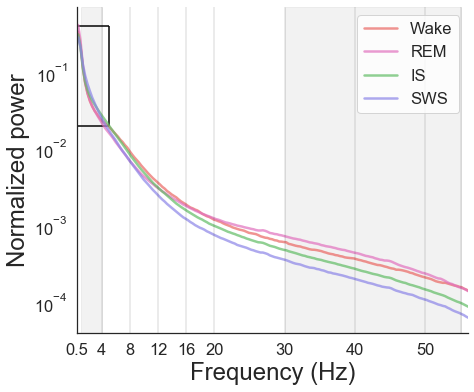

In [32]:
plt.figure(figsize=figsize)

which_stages = [0,5,3,4]

spectra_to_plot= all_spectra_by_stage_normalized


# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
#ax.set_xscale('log')

xticks = [0.5, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xlim(.5,56)
plt.ylim(4*10**(-5), .7)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)
plt.xticks(xticks,xticks)

# plot a box around the range of the delta inset
delta_x = [0.5, 5]
delta_y = [.02, .4]
plt.vlines(delta_x, delta_y[0], delta_y[1])
plt.hlines(delta_y, delta_x[0], delta_x[1])



sns.despine()


if savePlots:
    plt.savefig(saveAsPath + saveAsName + "4b_power_spectra_All_sleep_vs_wake.pdf")

### Figure: wake vs drowsy vs IS

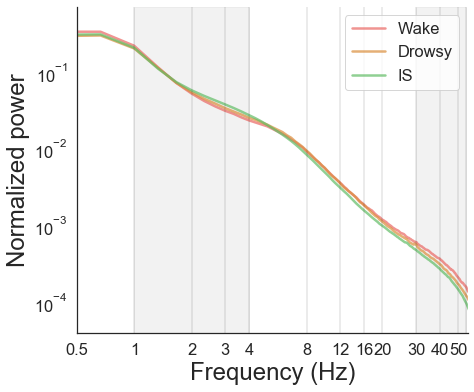

In [33]:
plt.figure(figsize=figsize)

which_stages = [0,1,3]

spectra_to_plot= all_spectra_by_stage_normalized

# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xlim(.5,56)
plt.ylim(4*10**(-5), .7)

plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Wake', 'Drowsy', 'IS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.xticks(xticks,xticks)

sns.despine()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_power_spectra_Wake_Drowsy_IS.pdf")

### Figure: drowsy vs US sleeping vs waking hemisphere

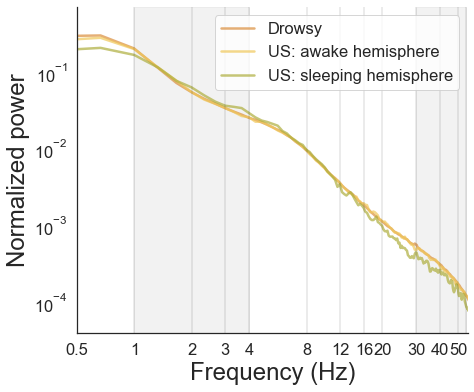

In [34]:
plt.figure(figsize=figsize)

which_stages = [1, 6, 2]

spectra_to_plot= all_spectra_by_stage_normalized

# Plot SEMs
for st in which_stages:
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]
    
    spectra_std_higher = spectra.mean(axis=0) + spectra.std(axis=0)
    spectra_std_lower  = spectra.mean(axis=0) - spectra.std(axis=0)

    spectra_sem_higher = spectra.mean(axis=0) + (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = spectra.mean(axis=0) - (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    
    #for ch in range(len(EEGchannels)):
        #plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st], linewidth=0, alpha=.02)

# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]
    
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')


xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xlim(.5,56)
plt.ylim(4*10**(-5), .7)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Drowsy', 'US: awake hemisphere', 'US: sleeping hemisphere'])
for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.xticks(xticks,xticks)

sns.despine()
    
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_power_spectra_US_vs_drowsy.pdf")
    

### Figure: US sleeping hemisphere vs IS/SWS/REM

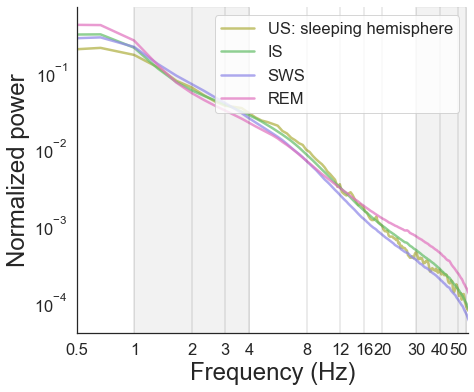

In [35]:
plt.figure(figsize=figsize)

which_stages = [2, 3, 4, 5]

spectra_to_plot= all_spectra_by_stage_normalized

# Plot SEMs
for st in which_stages:
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]
    
    spectra_std_higher = spectra.mean(axis=0) + spectra.std(axis=0)
    spectra_std_lower  = spectra.mean(axis=0) - spectra.std(axis=0)

    spectra_sem_higher = spectra.mean(axis=0) + (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = spectra.mean(axis=0) - (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    
    #for ch in range(len(EEGchannels)):
        #plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st], linewidth=0, alpha=.02)

# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]
    
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

# Legend & titles
#plt.legend(legendMarkersEEG, stages, loc=1)
#plt.text(8,.01,'US: sleeping hem', color=colors[2])
#plt.text(9,.002,'US: awake hem', color=colors[6])


xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xlim(.5,56)
plt.ylim(4*10**(-5), .7)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['US: sleeping hemisphere', 'IS', 'SWS', 'REM'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.xticks(xticks,xticks)


sns.despine()
    
#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_power_spectra_US_vs_sleep.pdf")

### Figure: Sleep + wake with SEMs

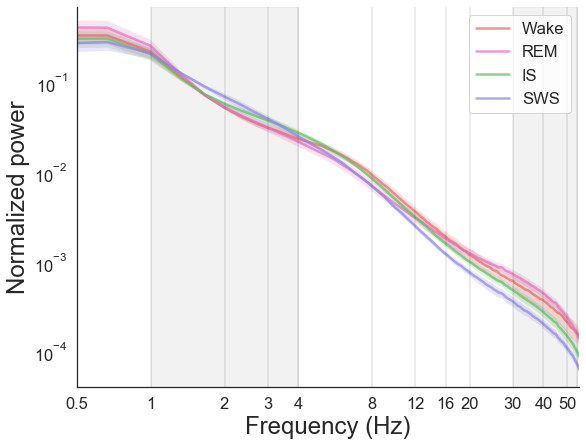

In [36]:
plt.figure(figsize=bigger_figsize)

which_stages = [0,5,3,4]

spectra_to_plot= all_spectra_by_stage_normalized


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(4*10**(-5), .7)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

sns.despine()

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_power_spectra_sleep_stages_SEMs.pdf")

### FIGURE 4A: delta range only

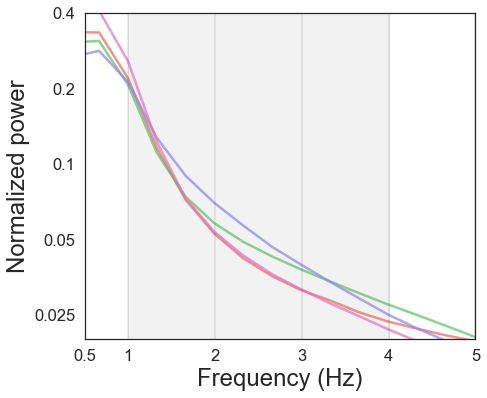

In [37]:
# Delta range inset

plt.figure(figsize=figsize)

which_stages = [0,3,4,5]

# Plot SEMs
for st in which_stages:
    spectra = spectra_to_plot[st]
    spectra_std_higher = spectra.mean(axis=0) + spectra.std(axis=0)
    spectra_std_lower  = spectra.mean(axis=0) - spectra.std(axis=0)

    spectra_sem_higher = spectra.mean(axis=0) + (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = spectra.mean(axis=0) - (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    
    #plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
    #                     linewidth=0, alpha=shading_alpha)

# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')

# Legend & titles
#plt.legend(legendMarkersEEG, stages, loc=1)
xticks = [0.5, 1, 2, 3, 4, 5]
plt.xticks(xticks,xticks)

yticks = [.025, .05, .1, .2, .4]
plt.yticks(yticks, yticks)

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)

plt.xlim(0.5, 5)
plt.ylim(.02, .4)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Normalized power', fontsize=axis_label_fontsize)
#plt.title('Mean power spectra')

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "4a_power_spectra_sleep_stages_Delta.pdf")

### Figure: Gamma range only

Text(0, 0.5, 'Power')

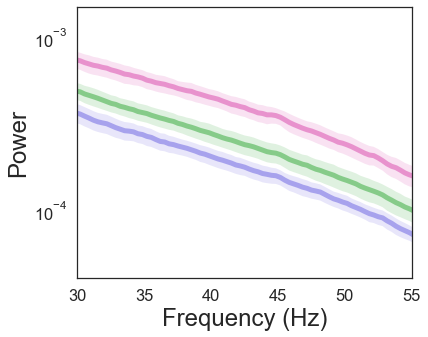

In [38]:
# Gamma range inset

plt.figure(figsize=smaller_figsize)

which_stages = [5,3,4]


# Plot SEMs
for st in which_stages:
    spectra = spectra_to_plot[st]
    spectra_std_higher = spectra.mean(axis=0) + spectra.std(axis=0)
    spectra_std_lower  = spectra.mean(axis=0) - spectra.std(axis=0)

    spectra_sem_higher = spectra.mean(axis=0) + (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = spectra.mean(axis=0) - (spectra.std(axis=0) / np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                         linewidth=0, alpha=shading_alpha)

# Plot means
for st in which_stages:
    spectra = spectra_to_plot[st]
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')

# Legend & titles
#plt.legend(legendMarkersEEG, stages, loc=1)
plt.xlim(30,55)
plt.ylim(.00004, .0015)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power', fontsize=axis_label_fontsize)
#plt.title('Mean power spectra')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_power_spectra_sleep_stages_Gamma.pdf")

### Raw power

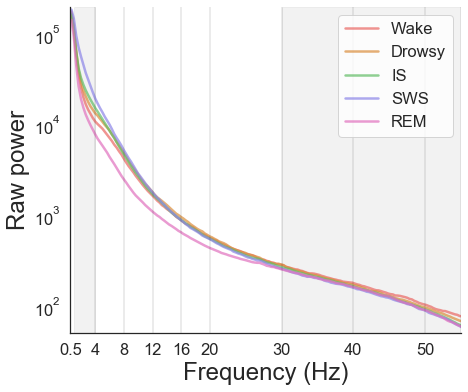

In [39]:
plt.figure(figsize=figsize)

which_stages = [0,1,3,4,5]

spectra_to_plot= all_spectra_by_stage


# Plot means
for st in which_stages:    
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    #plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
    #                 linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
#ax.set_xscale('log')

xticks = [0.5, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,55)
plt.ylim(50, 2*10**5)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Raw power', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Wake', 'Drowsy', 'IS', 'SWS', 'REM'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

sns.despine()

#plt.legend(legendMarkersEEG, ['Wake', 'Drowsy', 'Unihemispheric sleep', 'IS', 'SWS', 'REM'])

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_raw_power_spectra_all.pdf")

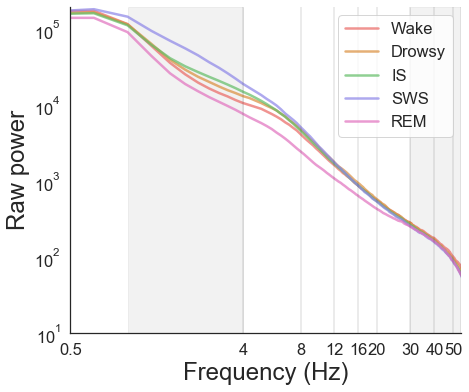

In [40]:
plt.figure(figsize=figsize)

which_stages = [0,1,3,4,5]

spectra_to_plot= all_spectra_by_stage


# Plot means
for st in which_stages:    
    spectra = spectra_to_plot[st]
    # drop rows (ie, birds) containing NaNs
    not_nan_inds = np.unique(np.where(~np.isnan(all_spectra_by_stage_normalized[st]))[0])
    spectra = spectra[not_nan_inds, :]
    
    # take log before plotting
    plt.plot(freqs, spectra.mean(axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

    
# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,55)
plt.ylim(10, 2*10**5)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Raw power', fontsize=axis_label_fontsize)

plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

plotLegend(which_stages, ['Wake', 'Drowsy', 'IS', 'SWS', 'REM'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

sns.despine()

#plt.legend(legendMarkersEEG, ['Wake', 'Drowsy', 'Unihemispheric sleep', 'IS', 'SWS', 'REM'])

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_raw_power_spectra_all_log.pdf")

## FIGURE 4C STATS: RUGER AREAS

In [41]:
spectra_ttests = DataFrame([], index=freqs, columns=['IS vs SWS', 'IS vs REM', 'SWS vs REM',
                                                     'wake vs REM', 'wake vs drowsy'])

for freq in range(len(freqs)):
    
    spectra_is = all_spectra_by_stage_normalized[3][:,freq]
    spectra_sws = all_spectra_by_stage_normalized[4][:,freq]
    spectra_rem = all_spectra_by_stage_normalized[5][:,freq]
    spectra_wake = all_spectra_by_stage_normalized[0][:,freq]
    spectra_drowsy = all_spectra_by_stage_normalized[1][:,freq]

    
    t, p = stat.ttest_rel(spectra_is, spectra_sws)
    spectra_ttests['IS vs SWS'].iloc[freq] = p
    
    t, p = stat.ttest_rel(spectra_is, spectra_rem)
    spectra_ttests['IS vs REM'].iloc[freq] = p

    t, p = stat.ttest_rel(spectra_sws, spectra_rem)
    spectra_ttests['SWS vs REM'].iloc[freq] = p
    
    t, p = stat.ttest_rel(spectra_wake, spectra_rem)
    spectra_ttests['wake vs REM'].iloc[freq] = p
    
    t, p = stat.ttest_rel(spectra_wake, spectra_drowsy)
    spectra_ttests['wake vs drowsy'].iloc[freq] = p

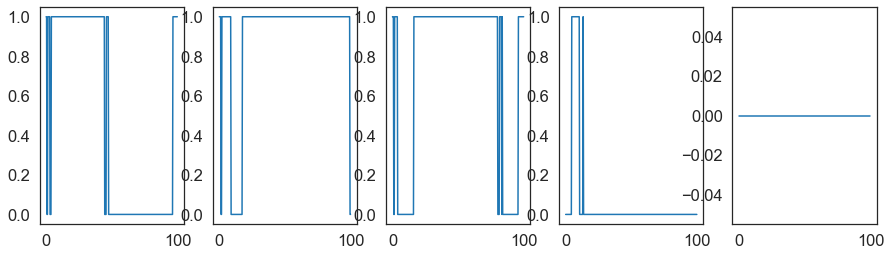

In [42]:
plt.figure(figsize=(15,4))
alpha=0.05

plt.subplot(1,5,1)
plt.plot(spectra_ttests['IS vs SWS']<alpha)

plt.subplot(1,5,2)
plt.plot(spectra_ttests['IS vs REM']<alpha)

plt.subplot(1,5,3)
plt.plot(spectra_ttests['SWS vs REM']<alpha)

plt.subplot(1,5,4)
plt.plot(spectra_ttests['wake vs REM']<alpha)

plt.subplot(1,5,5)
plt.plot(spectra_ttests['wake vs drowsy']<alpha)

In [43]:
# Identify Ruger areas: http://www.sciencedirect.com/science/article/pii/S0031938414001838?via%3Dihub#bb0005

# 1. neighbouring, consecutive frequency bins
# which contain a significant result surrounded by bins containing non-significant results

row=0
for column in ['IS vs SWS', 'IS vs REM', 'SWS vs REM', 'wake vs REM']:
    print('\n', column)
    data = spectra_ttests[column]
    significant = data<alpha

    area_starts = np.where(np.diff(significant.astype('int'))==1)[0] + 1
    area_stops = np.where(np.diff(significant.astype('int'))==-1)[0] + 1

    nAreas = max(len(area_starts), len(area_stops))
    isArea  = np.zeros_like(data)
    isRuger = np.zeros_like(data)
    if nAreas > 0:
        if (len(area_starts) == 0):
            area_starts = np.append(0, area_starts)
        elif (len(area_stops) == 0):
            area_stops = np.append(area_stops, len(freqs)-1)
        
        if area_starts[0]>area_stops[0]:
            area_starts = np.append(0, area_starts)
        
        if area_starts[-1]>area_stops[-1]:
            area_stops = np.append(area_stops,len(data))
            
        nAreas = max(len(area_starts), len(area_stops))
        
        for a in range(nAreas):
            print('Area ', a, ': ', freqs[area_starts[a]], ' - ', freqs[area_stops[a]-1])
            area = data.iloc[area_starts[a]:area_stops[a]]
            
            # 2. area larger than 1 bin
            if len(area)>1:
                print('\t area >1 bin')

                # SAVE AS TREND
                isArea[area_starts[a]:area_stops[a]] = 1

                
                # 3. at least half of these results were significant 
                #    at least at half of the conventional p=0.05 significance level (that is, whether they were below 0.025)
                nbinsInArea = len(area)
                nLessThanHalf = np.sum(area < (alpha/2))

                print('\t', nLessThanHalf, '/', nbinsInArea)

                if nLessThanHalf/nbinsInArea >= 1/2:

                   # 4.  and at least one third of them were significant
                   #     at least at a third of the conventional p=0.05 significance level (below 0.0167). 
                    nLessThanThird = np.sum(area < (alpha/3))

                    print('\t', nLessThanThird, '/', nbinsInArea)

                    if nLessThanThird/nbinsInArea >= 1/3:
                        print('\t RUGER AREA')
                        isRuger[area_starts[a]:area_stops[a]] = 1

    spectra_ttests[(column+' area')] = isArea
    spectra_ttests[(column+' Ruger area')] = isRuger


 IS vs SWS
Area  0 :  0.0  -  0.33222591362126247
	 area >1 bin
	 1 / 2
	 1 / 2
	 RUGER AREA
Area  1 :  1.3289036544850499  -  2.6578073089700998
	 area >1 bin
	 3 / 5
	 2 / 5
	 RUGER AREA
Area  2 :  3.98671096345515  -  44.18604651162791
	 area >1 bin
	 38 / 122
Area  3 :  45.84717607973422  -  47.17607973421927
	 area >1 bin
	 0 / 5
Area  4 :  96.34551495016612  -  99.66777408637874
	 area >1 bin
	 8 / 11
	 8 / 11
	 RUGER AREA

 IS vs REM
Area  0 :  0.0  -  0.9966777408637875
	 area >1 bin
	 4 / 4
	 3 / 4
	 RUGER AREA
Area  1 :  1.993355481727575  -  8.637873754152825
	 area >1 bin
	 19 / 21
	 15 / 21
	 RUGER AREA
Area  2 :  17.60797342192691  -  99.00332225913621
	 area >1 bin
	 177 / 246
	 149 / 246
	 RUGER AREA

 SWS vs REM
Area  0 :  0.0  -  0.6644518272425249
	 area >1 bin
	 3 / 3
	 3 / 3
	 RUGER AREA
Area  1 :  1.6611295681063123  -  3.654485049833887
	 area >1 bin
	 5 / 7
	 5 / 7
	 RUGER AREA
Area  2 :  16.27906976744186  -  79.734219269103
	 area >1 bin
	 137 / 192
	 115 / 1

### FIGURE 4C BOTTOM

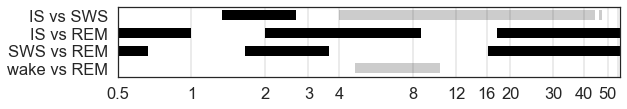

In [44]:
plt.figure(figsize=(bigger_figsize[0],1.3))
row = 4 # init

for column in ['IS vs SWS', 'IS vs REM', 'SWS vs REM', 'wake vs REM']:
        
#### plot trends (p < 0.05) in grey
    data = spectra_ttests[column+' area']

    area_starts = data.iloc[1::][np.diff(data.astype('int'))==1].index
    area_stops = data.iloc[0:-1][np.diff(data.astype('int'))==-1].index
    
    if data.iloc[0]==1:
        area_starts = np.append(data.index[0], area_starts)
    if data.iloc[-1]==1:
        area_stops = np.append(area_stops, data.index[-1])
        
    nAreas = max(len(area_starts), len(area_stops))
    if len(area_starts) != len(area_stops):
        print(column, 'unequal number of area starts and stops')
        
    for a in range(nAreas):

        plt.hlines(row, area_starts[a], area_stops[a], color=[.8,.8,.8], lw=10)
    
#### plot Ruger areas in black
    data = spectra_ttests[column+' Ruger area']
    area_starts = data.iloc[1::][np.diff(data.astype('int'))==1].index
    area_stops = data.iloc[0:-1][np.diff(data.astype('int'))==-1].index
    
    if data.iloc[0]==1: # check first freq bin
        area_starts = np.append(data.index[0], area_starts)
    if data.iloc[-1]==1: # check last freq bin
        area_stops = np.append(area_stops, data.index[-1])
        
    nAreas = max(len(area_starts), len(area_stops))
    if len(area_starts) != len(area_stops):
        print(column, 'unequal number of area starts and stops')
        
    for a in range(nAreas):
        plt.hlines(row, area_starts[a], area_stops[a], color='k', lw=10)
    row -= 1
    
plt.ylim(0.5, 4.5)
plt.yticks([1,2,3,4], ['wake vs REM', 'SWS vs REM', 'IS vs REM', 'IS vs SWS']);
plt.xlim(0.5, 56)

# log scale
ax = plt.gca()
ax.set_xscale('log')
xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "4c_bottom_ttests_spectra_log.pdf")

# Plot spectra relative to one stage

In [45]:
# relative to IS

stage_to_norm_to = 3

all_spectra_relativeIS = {}
for i,ch in enumerate(EEGchannels):
    spectra = all_spectra_normalized[ch]
    
    spectra_relative = spectra/spectra[stage_to_norm_to]
    
    all_spectra_relativeIS[ch] = spectra_relative

In [46]:
# relative to Wake

stage_to_norm_to = 0

all_spectra_relativeWake = {}
for i,ch in enumerate(EEGchannels):
    spectra = all_spectra_normalized[ch]
    
    spectra_relative = spectra/spectra[stage_to_norm_to]
    
    all_spectra_relativeWake[ch] = spectra_relative

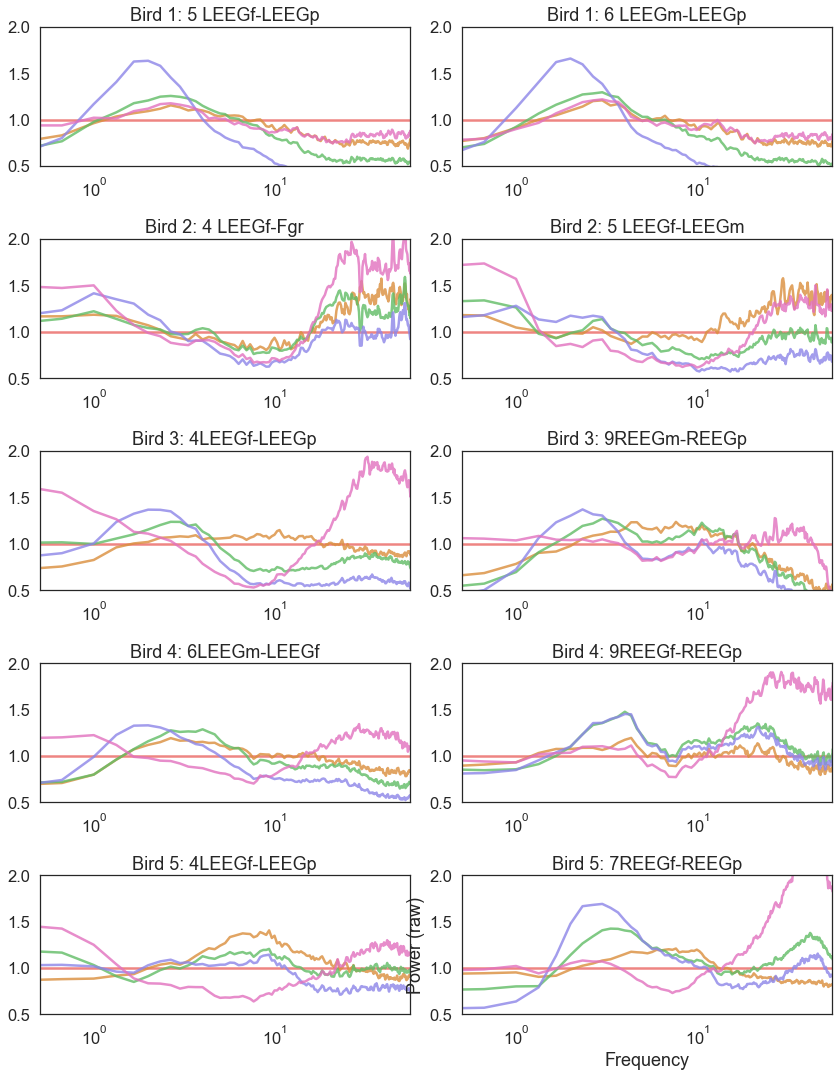

In [47]:
which_stages = [0,1,3,4,5]

plt.figure(figsize=(12,15))

for i,ch in enumerate(EEGchannels):
    spectra = all_spectra_relativeWake[ch]
    
    plt.subplot(5,2,i+1)
    for st in which_stages:
        if not any(np.isnan(spectra[st])):
            plt.plot(freqs, spectra[st], color=colors[st], linewidth=linewidth/2, alpha=0.8)
            ax = plt.gca()
            #ax.set_yscale('log')
            ax.set_xscale('log')

    plt.xlim(0.5,56)
    plt.ylim(.5, 2)
    plt.title(ch)
    
    i = i+1
    
plt.tight_layout()
#plt.legend(legendMarkersEEG, stages, loc=1)
plt.xlabel('Frequency');
plt.ylabel('Power (raw)');

In [48]:
all_spectra_by_stage_relativeIS = organize_spectra_by_stage(all_spectra_relativeIS)
all_spectra_by_stage_relativeWake = organize_spectra_by_stage(all_spectra_relativeWake)

/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


# FIGURE 4C

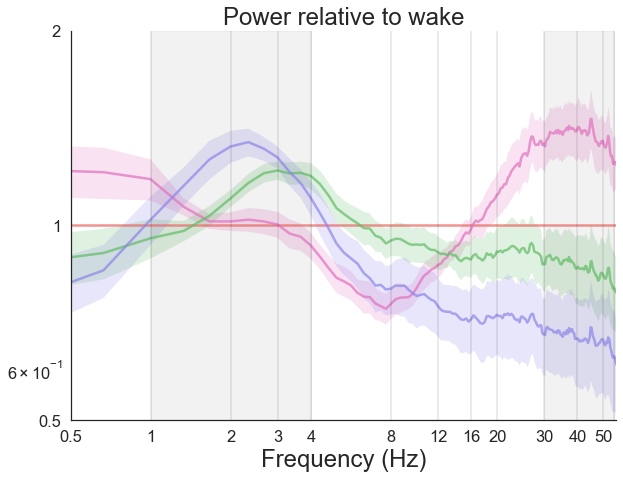

In [49]:
plt.figure(figsize=bigger_figsize)

which_stages = [0,5,3,4]

spectra_to_plot= all_spectra_by_stage_relativeWake


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.title('Power relative to wake', fontsize=axis_label_fontsize)

# label frequency bands
plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.yticks([0.5,1,2], [0.5,1,2])

sns.despine()
plt.tight_layout()

if savePlots:
    plt.savefig(saveAsPath + saveAsName + "4c_relative_power_spectra_sleep_stages_SEMs.pdf")
    

# FIGURE S2a

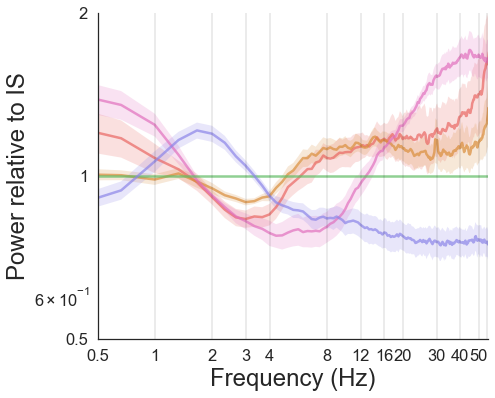

In [51]:
plt.figure(figsize=figsize)

which_stages = [0,1,5,3,4]

spectra_to_plot= all_spectra_by_stage_relativeIS


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power relative to IS', fontsize=axis_label_fontsize)

# label frequency bands
#plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

#plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.yticks([0.5,1,2], [0.5,1,2])

sns.despine()

if savePlots:
    plt.savefig('./Fig S2/' + saveAsName + "S2a_relative_power_spectra_wake_drowsy_IS.pdf")
    

# FIGURE S2b

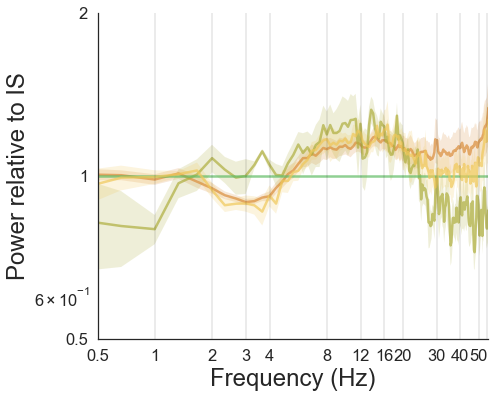

In [52]:
plt.figure(figsize=figsize)

which_stages = [1,2,3,6]

spectra_to_plot= all_spectra_by_stage_relativeIS


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power relative to IS', fontsize=axis_label_fontsize)

# label frequency bands
#plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

#plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

yticks = [0.5, 1, 2]
plt.yticks(yticks, yticks)

sns.despine()

if savePlots:
    plt.savefig('./Fig S2/' + saveAsName + "S2b_relative_power_spectra_US_vs_drowsy.pdf")
    

# FIGURE S2c

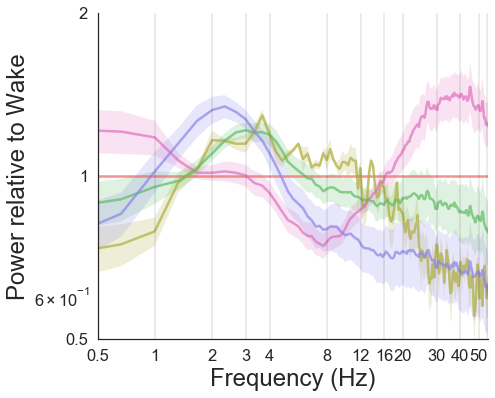

In [56]:
plt.figure(figsize=figsize)

which_stages = [0,2,5,3,4]

spectra_to_plot= all_spectra_by_stage_relativeWake


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power relative to Wake', fontsize=axis_label_fontsize)

# label frequency bands
#plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

#plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.yticks([0.5,1,2], [0.5,1,2])

sns.despine()

if savePlots:
    plt.savefig('./Fig S2/' + saveAsName + "S2c_relative_power_spectra_US_vs_sleep.pdf")
    

## US relative spectra using only US channels

In [57]:
# only channels for which there is US sleeping hem data
# relative to Wake

stage_to_norm_to = 0

USsleepch_spectra_relativeWake = {}
for i,ch in enumerate(EEGchannels):
    
    spectra = all_spectra_normalized[ch]
    
    if not any(np.isnan(spectra[2])):
    
        spectra_relative = spectra/spectra[stage_to_norm_to]
    
        USsleepch_spectra_relativeWake[ch] = spectra_relative

In [58]:
USsleepch_spectra_by_stage_relativeWake = organize_spectra_by_stage(USsleepch_spectra_relativeWake)


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'Only channels with US sleeping-hem data')

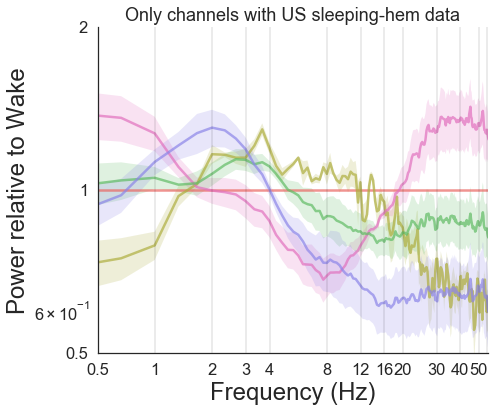

In [59]:
plt.figure(figsize=figsize)

which_stages = [0,2,5,3,4]

spectra_to_plot= USsleepch_spectra_by_stage_relativeWake


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power relative to Wake', fontsize=axis_label_fontsize)

# label frequency bands
#plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

#plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.yticks([0.5,1,2], [0.5,1,2])

sns.despine()
plt.title('Only channels with US sleeping-hem data')

#if savePlots:
#    plt.savefig('./Fig S2/' + saveAsName + "4_relative_power_spectra_US_vs_sleep__onlyUSch.pdf")


In [60]:
# only channels for which there is US awake hem data
# relative to IS

stage_to_norm_to = 3

USwakech_spectra_relativeIS = {}
for i,ch in enumerate(EEGchannels):
    
    spectra = all_spectra_normalized[ch]
    
    if not any(np.isnan(spectra[6])):
    
        spectra_relative = spectra/spectra[stage_to_norm_to]
    
        USwakech_spectra_relativeIS[ch] = spectra_relative

In [61]:
USwakech_spectra_by_stage_relativeIS = organize_spectra_by_stage(USwakech_spectra_relativeIS)


/Users/svcanavan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


Text(0.5, 1.0, 'Only channels with US awake-hem data')

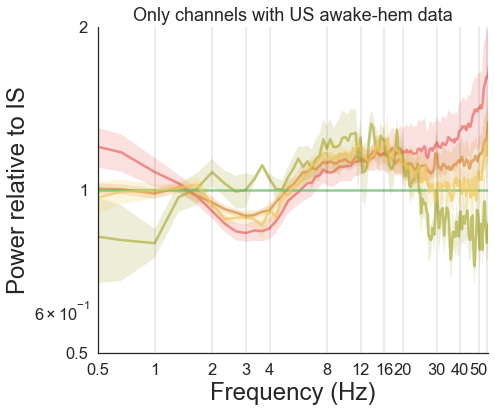

In [62]:
plt.figure(figsize=figsize)

which_stages = [0,1,2,3,6]

spectra_to_plot= USwakech_spectra_by_stage_relativeIS


for st in which_stages:
    spectra = spectra_to_plot[st]

    # Plot SEMs
    spectra_sem_higher = np.nanmean(spectra, axis=0) + (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    spectra_sem_lower  = np.nanmean(spectra, axis=0) - (np.nanstd(spectra, axis=0)/np.sqrt(spectra.shape[0]))
    
    plt.fill_between(freqs, spectra_sem_lower, spectra_sem_higher, color=colors[st],
                     linewidth=0, alpha=shading_alpha)

    # Plot means
    plt.plot(freqs, np.nanmean(spectra, axis=0), color=colors[st], linewidth=linewidth/2, alpha=linealpha)

# Log scaling
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

xticks = [0.5, 1, 2, 3, 4, 8, 12, 16, 20, 30, 40, 50]
plt.xticks(xticks,xticks)
plt.xlim(.5,56)
plt.ylim(.5,2)
plt.xlabel('Frequency (Hz)', fontsize=axis_label_fontsize)
plt.ylabel('Power relative to IS', fontsize=axis_label_fontsize)

# label frequency bands
#plt.axvspan(1,4, color='k', alpha=.05)
#plt.text(1.6,.2,'1-4 Hz', fontsize=axis_label_fontsize/1.5)

#plt.axvspan(30,55, color='k', alpha=.05)
#plt.text(30,.2,'30-55 Hz', fontsize=axis_label_fontsize/1.5)

#plotLegend(which_stages, ['Wake', 'REM', 'IS', 'SWS'])

for tick in xticks:
    plt.axvline(tick, color='k', alpha=.1)
plt.axvline(55, color='k', alpha=.1)

plt.yticks([0.5,1,2], [0.5,1,2])

sns.despine()
plt.title('Only channels with US awake-hem data')

#if savePlots:
#    plt.savefig('./Fig S2/' + saveAsName + "4_relative_power_spectra_US_vs_drowsy__onlyUSch.pdf")


# Plot individual channels

## Examples: normalized spectra

Text(0.5, 1.0, 'Bird 1: 5 LEEGf-LEEGp: Average spectra normalized')

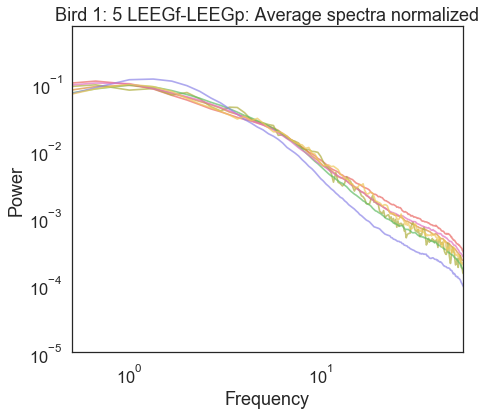

In [63]:
ch = 'Bird 1: 5 LEEGf-LEEGp'
spectra = all_spectra_normalized[ch]

plt.figure(figsize=figsize)
for st in [0,1,2,3,4,5,6]:
    plt.plot(freqs, spectra[st], color=colors[st], linewidth=linewidth/3, alpha=linealpha)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.xlim(0.5,55)
plt.ylim(.00001, .7)

plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(ch + ': Average spectra normalized')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_normalized_" + "B" + birdNum + "_ch_" + ch[9::] + ".pdf")

Text(0.5, 1.0, 'Bird 2: 5 LEEGf-LEEGm: Average spectra normalized')

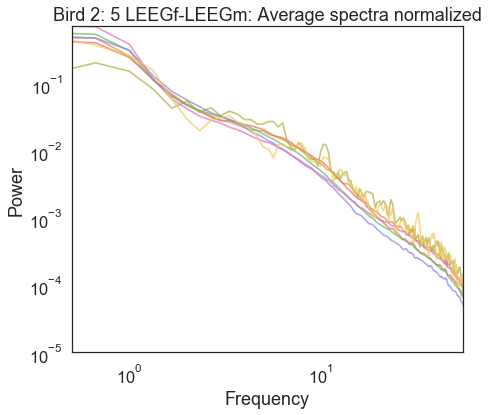

In [64]:
ch = 'Bird 2: 5 LEEGf-LEEGm'
spectra = all_spectra_normalized[ch]

plt.figure(figsize=figsize)
for st in [0,1,2,3,4,5,6]:
    plt.plot(freqs, spectra[st],  color=colors[st], linewidth=linewidth/3, alpha=linealpha)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')

plt.xlim(0.5,55)
plt.ylim(.00001, .7)

plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(ch + ': Average spectra normalized')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_normalized_" + "B" + birdNum + "_ch_" + ch[9::] + ".pdf")

Text(0.5, 1.0, 'Bird 3: 4LEEGf-LEEGp: Average spectra normalized')

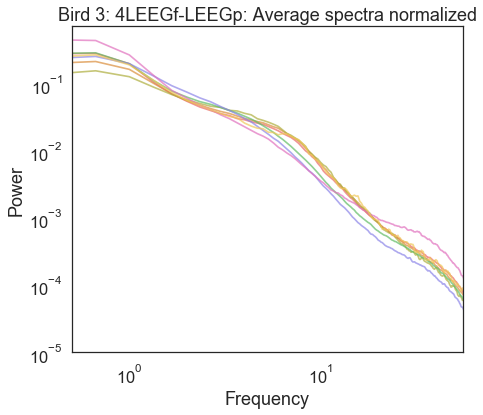

In [65]:
ch = 'Bird 3: 4LEEGf-LEEGp'
spectra = all_spectra_normalized[ch]

plt.figure(figsize=figsize)
for st in [0,1,2,3,4,5,6]:
    plt.plot(freqs, spectra[st], color=colors[st], linewidth=linewidth/3, alpha=linealpha)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.xlim(0.5,55)
plt.ylim(.00001, .7)

plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(ch + ': Average spectra normalized')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_normalized_" + "B" + birdNum + "_ch_" + ch[9::] + ".pdf")

Text(0.5, 1.0, 'Bird 4: 6LEEGm-LEEGf: Average spectra normalized')

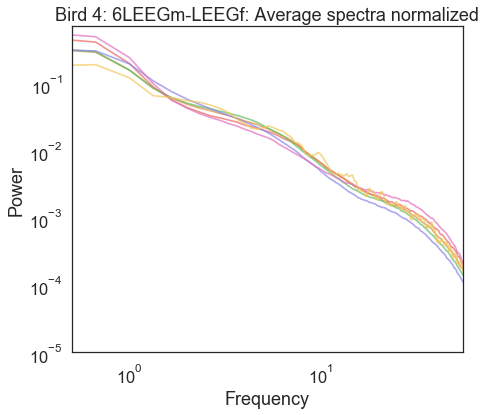

In [66]:
ch = 'Bird 4: 6LEEGm-LEEGf'
spectra = all_spectra_normalized[ch]

plt.figure(figsize=figsize)
for st in [0,1,2,3,4,5,6]:
    plt.plot(freqs, spectra[st], color=colors[st], linewidth=linewidth/3, alpha=linealpha)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.xlim(0.5,55)
plt.ylim(.00001, .7)

plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(ch + ': Average spectra normalized')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "_normalized_" + "B" + birdNum + "_ch_" + ch[9::] + ".pdf")

Text(0.5, 1.0, 'Bird 5: 7REEGf-REEGp: Average spectra normalized')

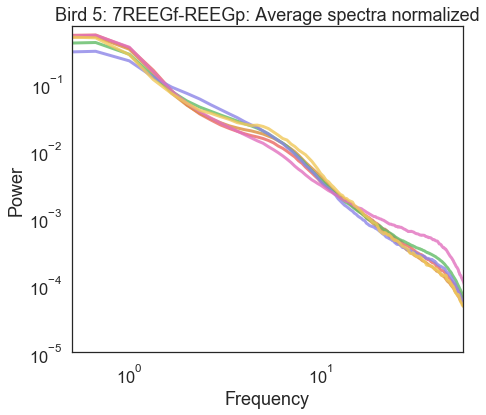

In [67]:
ch = 'Bird 5: 7REEGf-REEGp'
spectra = all_spectra_normalized[ch]

plt.figure(figsize=figsize)
for st in [0,1,2,3,4,5,6]:
    plt.plot(freqs, spectra[st], color=colors[st], linewidth=3, alpha=0.8)
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.xlim(0.5,55)
plt.ylim(.00001, .7)

plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title(ch + ': Average spectra normalized')

#if savePlots:
#    plt.savefig(saveAsPath + saveAsName + "4_normalized_" + "B" + birdNum + "_ch_" + ch[9::] + ".pdf")